In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib as tpl
import torch

In [2]:
from scipy.special import gamma
from scipy.linalg import expm, sqrtm, logm
from scipy.stats import multivariate_normal as mv_norm
from scipy.stats import wishart, chi2

%matplotlib inline

In [3]:
# Make inline plots vector graphics
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

#matplotlib.rc("font", **{"family": "serif", "serif": ["Times Roman"]})
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"

In [4]:
def is_pos_def(x):
    eig = np.linalg.eigvals(x)
    pd = np.all(eig > 0)
    if not pd:
        raise(ValueError("matrix is not positive definite! Matrix: {}; Eigenvalues: {}".format(x, eig)))
    else:
        return(True)
    
def my_kron_product(A, B):
    m_1, n_1 = A.shape[0], A.shape[1]
    m_2, n_2 = B.shape[0], B.shape[1]
    K = np.zeros((m_1*m_2, n_1*n_2))
    for i in range(m_1):
        for j in range(m_2):
            for k in range(n_1):
                for l in range(n_2):
                    K[i*m_2 +j, k*n_2 + l] = A[i,k] * B[j,l]
    
    return(K)
    
def my_box_product(A, B):
    m_1, n_1 = A.shape[0], A.shape[1]
    m_2, n_2 = B.shape[0], B.shape[1]
    K = np.zeros((m_1*m_2, n_1*n_2))
    for i in range(m_1):
        for j in range(m_2):
            for k in range(n_1):
                for l in range(n_2):
                    K[i*m_2 +j, k*n_1 + l] = A[i,l] * B[j,k]
    
    return(K)

def my_sym_kron_product(A, B):
    
    m_1, n_1 = A.shape[0], A.shape[1]
    m_2, n_2 = B.shape[0], B.shape[1]
    K = np.zeros((m_1*m_2, n_1*n_2))
    for i in range(m_1):
        for j in range(m_2):
            for k in range(n_1):
                for l in range(n_2):
                    v = 1/4 * (A[i,k]*B[j,l] + A[i,l]*B[j,k] + A[j,k]*B[i,l] + A[j,l]*B[i,k])
                    K[i*m_2 +j, k*n_1 + l] = v
                    
    return(K)

# return a cut through a 2D psd_cone, given values for the 
# a_11 and a_22 position of the matrix and a constant rho
def make_2D_psd_cone_cut(a_11, a_22, rho):
    xx = []
    
    for i in range(len(a_11)):
        a_12 = rho*np.sqrt(a_11[i] * a_22[i])
        matrix = np.array([[a_11[i], a_12],[a_12, a_22[i]]])
        is_pos_def(matrix)
        xx.append(matrix)
        
    return(xx)

def multi_variate_gamma(p, a):
    a = np.pi**(p*(p-1)/4) 
    b = np.prod([gamma(a + (1-j)/2) for j in range(1, p + 1)])
    return(a*b)

def create_spd_matrix(p=2, eps=10e-3):
    
    #create two symmetric positive-definite matrices
    X_ = torch.rand(p,p)
    X_sym = (X_ + X_.T)/2
    lambda_X_min = torch.abs(torch.min(torch.eig(X_sym, False)[0])) + eps
    X_spd = X_sym + torch.eye(p) * lambda_X_min
    print("X_spd is spd: ", is_pos_def(X_spd))
    
    return(X_spd.cpu().numpy())

    

(301, 2, 2)
(301,)


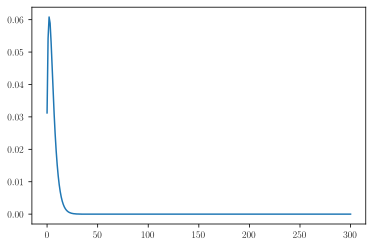

In [5]:
# test the make_2D_psd_cone_cut function
a_11 = np.linspace(0.1, 30.1, 300 +1)
a_22 = np.linspace(0.1, 60.1, 300 +1)
rho = 0

s = 0.2 * np.array([[4,2],
             [2,3]])
is_pos_def(s)

xx = make_2D_psd_cone_cut(a_11, a_22, rho)

w = []
print(np.shape(xx))
for x in xx:
    w_ = wishart.pdf(x, df=4, scale=s)
    w.append(w_)
print(np.shape(w))

plt.plot(w);
plt.show()

# Wishart Distribution Laplace Propagation

In [6]:


def make_Gamma(n):
    
    Gamma = np.zeros((n**2, n**2))
    I = np.eye(n)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    Gamma[i*n +j, k*n + l] = 1/2 * (I[i,k]*I[j,l] + I[i,l]*I[j,k])
    
    return(Gamma)


def make_Delta(n):
    
    Delta = np.zeros((n**2, n**2))
    I = np.eye(n)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    Delta[i*n +j, k*n + l] = 1/2 * (I[i,k]*I[j,l] - I[i,l]*I[j,k])
    
    return(Delta)

D = make_Delta(2)
G = make_Gamma(2)
print(G)
print(D)
print(D@G)
print(D@D)
print(G@D)
print(G@G)

def make_U(n):
    G = make_Gamma(n)
    eig_values, eig_vectors = np.linalg.eig(G)
    U = []
    #print(eig_vectors, eig_values)
    for i, v in enumerate(eig_values):
        if v == 1:
            U.append(eig_vectors[i])

    U = np.array(U)
    return(U)

[[1.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  1. ]]
[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  1. ]]


In [7]:
#### WARNING: these implementations are not yet optimized for performance. ########

def wishart_pdf(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(X)**((n-p-1)/2) * np.exp(-np.trace(np.linalg.inv(V) @ X)/2)
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)

def wishart_pdf_t_sqrtm(X, n, V):
    p = np.shape(X)[0]
    nom = 2**p * np.linalg.det(X)**(n-p) * np.exp(-np.trace(np.linalg.inv(V) @ (X.T@X))/2) 
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)

def wishart_pdf_t_logm(X, n, V):
    p = np.shape(X)[0]
    nom = np.linalg.det(expm(X))**((n-p+1)/2) * np.exp(-0.5 * np.trace(np.linalg.inv(V) @ expm(X))) 
    den = 2**(n*p/2) * np.linalg.det(V)**(n/2) * multi_variate_gamma(p, n/2)
    return(nom/den)
    
def multivariate_normal_pdf_test_sym(X, mu, Sigma_inv):
    
    k = np.shape(X)[0]
    correction = (1/2*k*(k+1))/k**2 
    a = -k/2 * np.log(2*np.pi)
    U = make_U(2)
    b = 1/2*np.log(np.linalg.det(U@Sigma_inv@U.T))
    #b = 1/2*np.log(np.linalg.det(Sigma_inv)) 
    x_mu = (X-mu).reshape(-1)
    c = -1/2 * x_mu.T @ Sigma_inv @ x_mu
    return(correction * np.exp(a+b+c))

def multivariate_normal_pdf_test(X, mu, Sigma_inv):
    k = np.shape(X)[0]
    a = -k/2 * np.log(2*np.pi)
    b = 1/2*np.log(np.linalg.det(Sigma_inv))
    x_mu = (X-mu).reshape(-1)
    c = -1/2 * x_mu.T @ Sigma_inv @ x_mu
    return(np.exp(a+b+c))

def multivariate_normal_pdf_test_exp_log(X, mu, Sigma):
    k = np.shape(X)[0]
    a = -k/2 * np.log(2*np.pi)
    b = -1/2 * np.log(np.linalg.det(Sigma))
    x_mu = (X-mu).reshape(-1)
    c = -1/2 * x_mu.T @ np.linalg.inv(Sigma) @ x_mu
    return(np.exp(a+b+c))

def square_mv_normal_back(X, mu, Sigma):
    X_ = sqrtm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * np.linalg.det(sqrtm(X)))

def log_mv_normal_back(X, mu, Sigma):
    X_ = logm(X).reshape(-1)
    mu = mu.reshape(-1)
    return(mv_norm.pdf(X_, mu, Sigma) * np.linalg.det(np.linalg.inv(X)))

def wishart_mode(n, p, V):
    return((n-p-1) * V)

def wishart_Sigma(n, p, V):
    return(2*(n-p-1) * my_kron_product(V, V))

# sqrtm

def wishart_t_sqrtm_mode(n,p,V):
    return(sqrtm((n-p)*V))


def wishart_t_sqrtm_Sigma(n,p,V):
    V_inv = np.linalg.inv(V)
    V_inv_sqrtm = sqrtm(V_inv)
    I_p = np.eye(p)
    one = np.kron(V_inv_sqrtm, V_inv_sqrtm)
    two = np.kron(I_p, V_inv)
    #two = np.kron(V_inv, I_p)
    R = np.linalg.inv(one + two)
    return(R)


def wishart_t_sqrtm_Sigma_inv(n,p,V):
    V_inv = np.linalg.inv(V)
    V_inv_sqrtm = sqrtm(V_inv)
    I_p = np.eye(p)
    one = np.kron(V_inv_sqrtm, V_inv_sqrtm)
    two = np.kron(I_p, V_inv)
    R = one + two
    return(R)

"""
def wishart_t_sqrtm_Sigma2(n,p,V):
    
    beta = 1e-8
    
    V_inv = np.linalg.inv(V)
    V_inv_sqrtm = sqrtm(V_inv)
    I_p = np.eye(p)
    #one = my_sym_kron_product(V_inv_sqrtm, V_inv_sqrtm) 
    #two = my_sym_kron_product(I_p, V_inv)
    one = my_kron_product(V_inv_sqrtm, V_inv_sqrtm) 
    two = my_kron_product(I_p, V_inv)
    three = 1/beta * (np.kron(I_p, I_p) - my_box_product(I_p, I_p))
    R = np.linalg.inv((one + two + three))
    return(R)
"""

#"""
def wishart_t_sqrtm_Sigma2(n,p,V):
    
    beta = 1e-8
    
    V_inv = np.linalg.inv(V)
    V_inv_sqrtm = sqrtm(V_inv)
    I_p = np.eye(p)
    one = my_sym_kron_product(V_inv_sqrtm, V_inv_sqrtm) 
    two = my_sym_kron_product(I_p, V_inv)
    #one = my_kron_product(V_inv_sqrtm, V_inv_sqrtm) 
    #two = my_kron_product(I_p, V_inv)
    #three = 1/beta * (np.kron(I_p, I_p) - my_box_product(I_p, I_p))
    three = 1/2 * (np.kron(I_p, V_inv) - np.kron(V_inv, I_p))
    
    R = np.linalg.inv((one + two + three + np.eye(p**2)*beta))
    return(R)
#"""

def wishart_t_sqrtm_Sigma2_inv(n,p,V):
    
    beta = 1e-8
    
    V_inv = np.linalg.inv(V)
    V_inv_sqrtm = sqrtm(V_inv)
    I_p = np.eye(p)
    one = my_sym_kron_product(V_inv_sqrtm, V_inv_sqrtm) 
    two = my_sym_kron_product(I_p, V_inv)
    #one = my_kron_product(V_inv_sqrtm, V_inv_sqrtm) 
    #two = my_kron_product(I_p, V_inv)
    #three = 1/beta * (np.kron(I_p, I_p) - my_box_product(I_p, I_p))
    three = 1/2 * (np.kron(I_p, V_inv) - np.kron(V_inv, I_p))
    
    R = (one + two + three)
    return(R)
#"""


def wishart_t_sqrtm_Sigma3(n,p,V):
    
    V_inv = np.linalg.inv(V)
    V_inv_sqrtm = sqrtm(V_inv)
    I_p = np.eye(p)
    one = my_kron_product(V_inv_sqrtm, V_inv_sqrtm)
    two = 0.5 * (my_kron_product(I_p, V_inv) + my_box_product(V_inv, I_p))
    R = np.linalg.inv(one + two)
    is_pos_def(R)
    return(R)

# logm

def wishart_t_logm_mode(n, p, V):
    return(logm((n-p+1) * V))

def wishart_t_logm_Sigma(n, p, V):
    return(2/(n-p+1) * np.eye(p**2))
    

def wishart_t_logm_Sigma_inv(n, p, V):
    return((n-p+1)/2 * np.eye(p**2))

In [8]:
v = np.array([[4,2],
             [2,3]])

n = 4
p = 2
mode1_t_sqrtm = wishart_t_sqrtm_mode(n, p=p, V=v).reshape(-1)
sigma1_t_sqrtm = wishart_t_sqrtm_Sigma(n, p=p, V=v)
sigma1_t_sqrtm_inv = wishart_t_sqrtm_Sigma_inv(n, p=p, V=v)
#sigma1_t_sqrtm_inv = np.linalg.inv(sigma1_t_sqrtm)#wishart_t_sqrtm_Sigma_inv(n1, p=p, V=s)


x = 3*np.eye(p).reshape(-1)

print(multivariate_normal_pdf_test_sym(x, mode1_t_sqrtm, sigma1_t_sqrtm_inv))
print(multivariate_normal_pdf_test(x, mode1_t_sqrtm, sigma1_t_sqrtm_inv))
print(multivariate_normal_pdf_test_exp_log(x, mode1_t_sqrtm, sigma1_t_sqrtm))

print(np.linalg.det(my_sym_kron_product(np.eye(2), np.eye(2))))

0.003910131053831888
0.004026460598966166
0.004026460598966166
0.0


## sqrtm basis

In [9]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_Wishart_bridge_sqrtm(xx, xxt, ns, s, filename, p=2, save=False, show_back=True):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = wishart_mode(n1, p=p, V=s)
    mode2 = wishart_mode(n2, p=p, V=s)
    mode3 = wishart_mode(n3, p=p, V=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = wishart_Sigma(n1, p=p, V=s)
    sigma2 = wishart_Sigma(n2, p=p, V=s)
    sigma3 = wishart_Sigma(n3, p=p, V=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    w1 = []
    w2 = []
    w3 = []
    normal1 = []
    normal2 = []
    normal3 = []
    
    for x in xx:
        w_1 = wishart_pdf(X=x, n=n1, V=s)
        w_2 = wishart_pdf(X=x, n=n2, V=s)
        w_3 = wishart_pdf(X=x, n=n3, V=s)
        w1.append(w_1)
        w2.append(w_2)
        w3.append(w_3)
        w1_lpa = multivariate_normal_pdf_test_exp_log(X=x, mu=mode1, Sigma=sigma1)
        w2_lpa = multivariate_normal_pdf_test_exp_log(X=x, mu=mode2, Sigma=sigma2)
        w3_lpa = multivariate_normal_pdf_test_exp_log(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(w1_lpa)
        normal2.append(w2_lpa)
        normal3.append(w3_lpa)

    w1 = np.array(w1)
    w2 = np.array(w2)
    w3 = np.array(w3)
    
    rescale_normal1 = np.max(w1)/np.max(normal1)
    rescale_normal2 = np.max(w2)/np.max(normal2)
    rescale_normal3 = np.max(w3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    

    ######### square transformation

    mode1_t_sqrtm = wishart_t_sqrtm_mode(n1, p=p, V=s)
    mode2_t_sqrtm = wishart_t_sqrtm_mode(n2, p=p, V=s)
    mode3_t_sqrtm = wishart_t_sqrtm_mode(n3, p=p, V=s)

    sigma1_t_sqrtm = wishart_t_sqrtm_Sigma_inv(n1, p=p, V=s)
    sigma2_t_sqrtm = wishart_t_sqrtm_Sigma_inv(n2, p=p, V=s)
    sigma3_t_sqrtm = wishart_t_sqrtm_Sigma_inv(n3, p=p, V=s)
    print(sigma1_t_sqrtm)

    #is_pos_def(sigma1_t_sqrtm)
    #is_pos_def(sigma2_t_sqrtm)
    #is_pos_def(sigma3_t_sqrtm)

    w1_t_sqrtm = []
    w2_t_sqrtm = []
    w3_t_sqrtm = []
    w1_lpa_t_sqrtm = []
    w2_lpa_t_sqrtm = []
    w3_lpa_t_sqrtm = []

    for x in xxt:
        w_1 = wishart_pdf_t_sqrtm(X=x, n=n1, V=s)
        w_2 = wishart_pdf_t_sqrtm(X=x, n=n2, V=s)
        w_3 = wishart_pdf_t_sqrtm(X=x, n=n3, V=s)
        w1_t_sqrtm.append(w_1)
        w2_t_sqrtm.append(w_2)
        w3_t_sqrtm.append(w_3)
        #
        w1_lpa = multivariate_normal_pdf_test_sym(X=x, mu=mode1_t_sqrtm, Sigma_inv=sigma1_t_sqrtm)
        w2_lpa = multivariate_normal_pdf_test_sym(X=x, mu=mode2_t_sqrtm, Sigma_inv=sigma2_t_sqrtm)
        w3_lpa = multivariate_normal_pdf_test_sym(X=x, mu=mode3_t_sqrtm, Sigma_inv=sigma3_t_sqrtm)
        w1_lpa_t_sqrtm.append(w1_lpa)
        w2_lpa_t_sqrtm.append(w2_lpa)
        w3_lpa_t_sqrtm.append(w3_lpa)

    #rescale for visibility
    w1_t_sqrtm = np.array(w1_t_sqrtm)
    w2_t_sqrtm = np.array(w2_t_sqrtm)
    w3_t_sqrtm = np.array(w3_t_sqrtm)
    
    rescale1_t_sqrtm = np.max(w1_t_sqrtm)/np.max(w1_lpa_t_sqrtm)
    rescale2_t_sqrtm = np.max(w2_t_sqrtm)/np.max(w2_lpa_t_sqrtm)
    rescale3_t_sqrtm = np.max(w3_t_sqrtm)/np.max(w3_lpa_t_sqrtm)

    w1_lpa_t_sqrtm = np.array(w1_lpa_t_sqrtm) * rescale1_t_sqrtm
    w2_lpa_t_sqrtm = np.array(w2_lpa_t_sqrtm) * rescale2_t_sqrtm
    w3_lpa_t_sqrtm = np.array(w3_lpa_t_sqrtm) * rescale3_t_sqrtm 

    ######### back transform #########

    if show_back:
        w1_back = []
        w2_back = []
        w3_back = []

        for x in xx:
            w1_back.append(square_mv_normal_back(x, mode1_t_sqrtm, sigma1_t_sqrtm))
            w2_back.append(square_mv_normal_back(x, mode2_t_sqrtm, sigma2_t_sqrtm))
            w3_back.append(square_mv_normal_back(x, mode3_t_sqrtm, sigma3_t_sqrtm))

        rescale_back1 = np.max(w1)/np.max(w1_back)
        rescale_back2 = np.max(w2)/np.max(w2_back)
        rescale_back3 = np.max(w3)/np.max(w3_back)

        w1_back = np.array(w1_back) * rescale_back1
        w2_back = np.array(w2_back) * rescale_back2 
        w3_back = np.array(w3_back) * rescale_back3 
    
    """Plots"""
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 15
    legend_size=14
    xlabel_size=15
    ylabel_size=15
    title_size=16
    lw = 2

    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(10, 3))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(10, 3))
        
    axs[0].plot(w1, 'r-', lw=lw)
    axs[0].plot(w2, 'b-', lw=lw)
    axs[0].plot(w3, 'k-', lw=lw, label="$\mathcal{W}$")
    axs[0].plot(normal1, 'r--', lw=lw)
    axs[0].plot(normal2, 'b--', lw=lw)
    axs[0].plot(normal3, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size});

    axs[1].plot(w1_t_sqrtm, 'r', lw=lw)
    axs[1].plot(w2_t_sqrtm, 'b', lw=lw)
    axs[1].plot(w3_t_sqrtm, 'k', lw=lw, label="$\mathcal{W}$")
    axs[1].plot(w1_lpa_t_sqrtm, 'r--', lw=lw)
    axs[1].plot(w2_lpa_t_sqrtm, 'b--', lw=lw)
    axs[1].plot(w3_lpa_t_sqrtm, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])
    axs[1].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[1].set_title('Laplace in sqrtm basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size});

    if show_back:
        axs[2].plot(w1, 'r-', lw=lw)
        axs[2].plot(w2, 'b-', lw=lw)
        axs[2].plot(w3, 'k-', lw=lw, label="$\mathcal{W}$")
        axs[2].plot(w1_back, 'r--', lw=lw)
        axs[2].plot(w2_back, 'b--', lw=lw)
        axs[2].plot(w3_back, 'k--', lw=lw, label="$\mathcal{N}$")
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$g(x)$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
        axs[2].set_title('Back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});
    
    plt.tight_layout()

    if save:
        plt.savefig(filename)
    plt.show();

[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


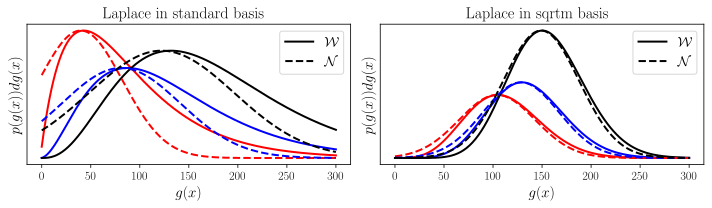

In [10]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 20.1, 300 +1)
a_22 = np.linspace(0.1, 20.1, 300 +1)

a_11_t = np.linspace(0.1, 7.1, 300 +1)
a_22_t = np.linspace(0.1, 7.1, 300 +1)

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

#s = 2*np.eye(2)
is_pos_def(s)

r = 0.4
xx = make_2D_psd_cone_cut(a_11, a_22, r)
xxt = make_2D_psd_cone_cut(a_11_t, a_22_t, r)

n1 = 4
n2 = 5
n3 = 6

p=2

plot_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False, 
                          filename='wishart_sqrtm_bridge.pdf', show_back=False)

-0.9
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


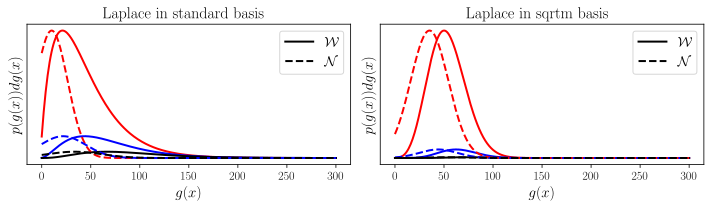

-0.8
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


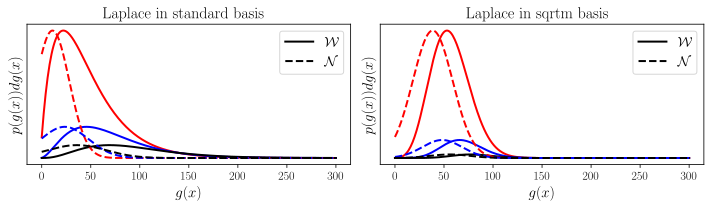

-0.7
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


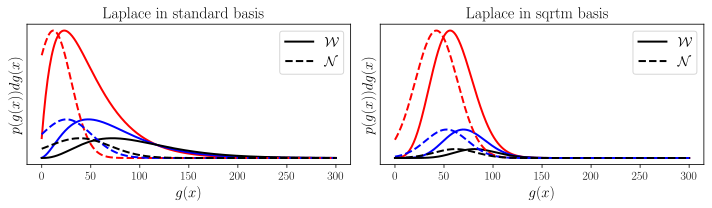

-0.6
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


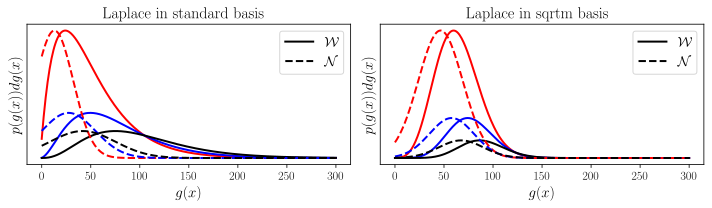

-0.5
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


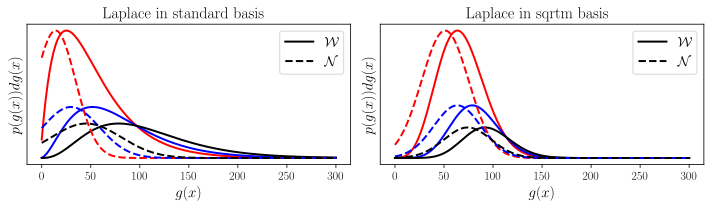

-0.4
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


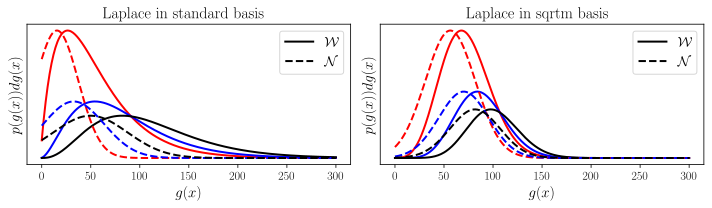

-0.29999999999999993
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


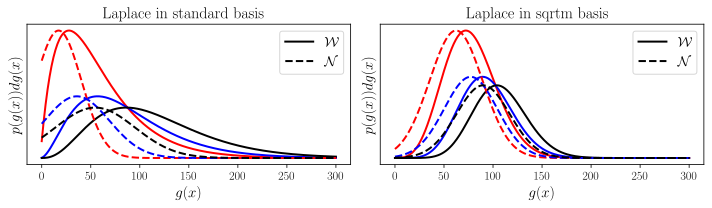

-0.19999999999999996
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


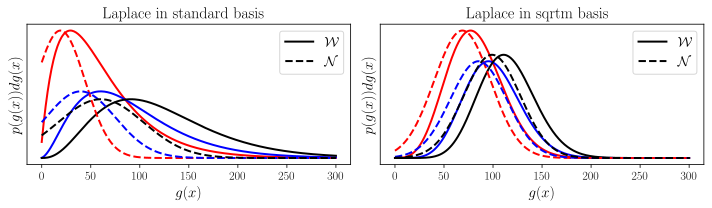

-0.09999999999999998
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


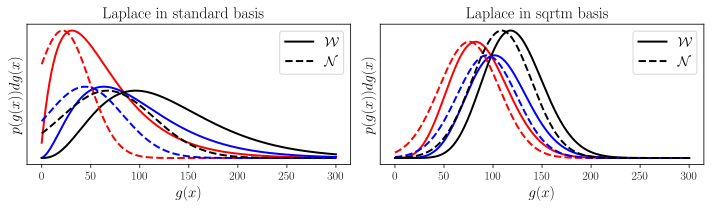

0.0
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


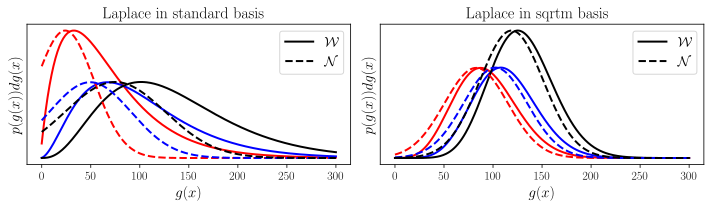

0.09999999999999998
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


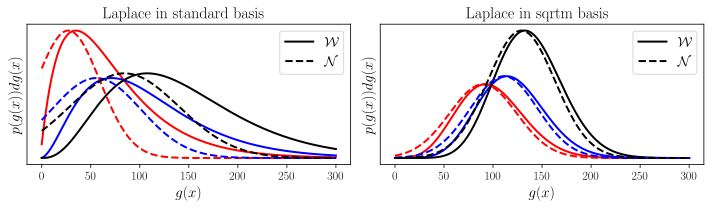

0.20000000000000007
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


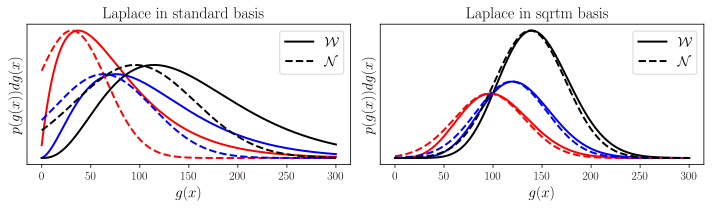

0.30000000000000016
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


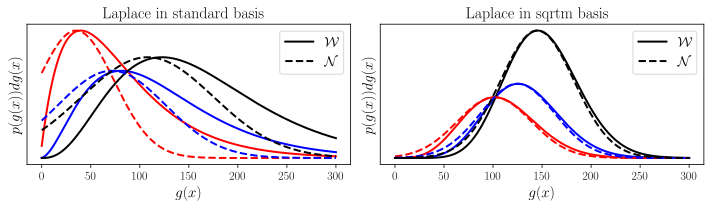

0.4
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


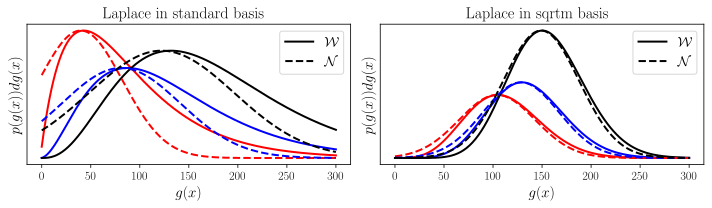

0.5000000000000001
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


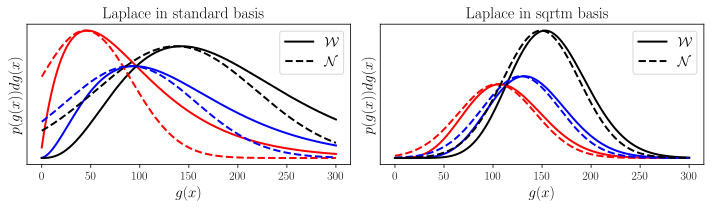

0.6
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


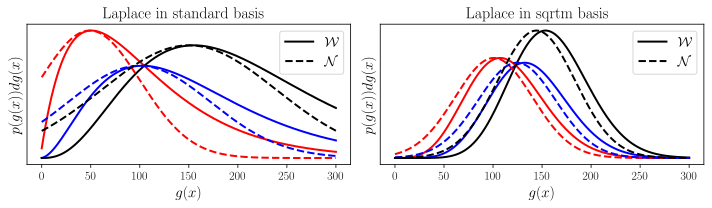

0.7000000000000001
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


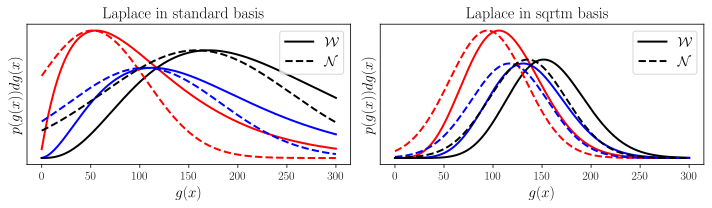

0.8000000000000002
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


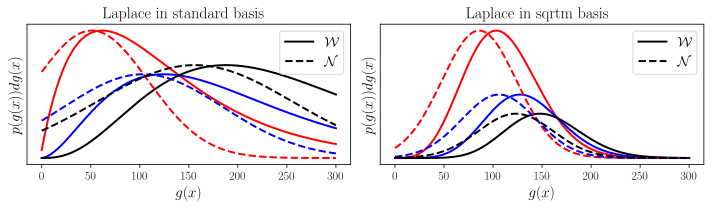

0.9
[[ 0.71049571 -0.36512393 -0.11512393  0.03950429]
 [-0.36512393  0.89305768  0.03950429 -0.13487607]
 [-0.11512393  0.03950429  0.76805768 -0.38487607]
 [ 0.03950429 -0.13487607 -0.38487607  0.96049571]]


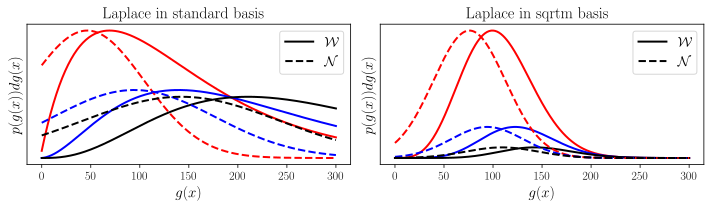

In [11]:
# test the function for multiple values of rho and s

""" values """

#s = np.eye(2)*2

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

n1 = 4
n2 = 5
n3 = 6

p=2

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    print(r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    xxt = make_2D_psd_cone_cut(a_11_t, a_22_t, r)
    plot_Wishart_bridge_sqrtm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False, filename='', show_back=False)

## logm basis

In [12]:
# function that creates a fancy plot for three different values of n
# the plot contains the original Laplace approximation, the Bridge, and a back transform

def plot_Wishart_bridge_logm(xx, xxt, ns, s, filename, p=2, save=False, show_back=True):
    
    n1, n2, n3 = ns
    
    ##### normal laplace
    
    mode1 = wishart_mode(n1, p=p, V=s)
    mode2 = wishart_mode(n2, p=p, V=s)
    mode3 = wishart_mode(n3, p=p, V=s)
    #print("mode1: ", mode1)
    #print("mode2: ", mode2)
    #print("mode3: ", mode3)

    sigma1 = wishart_Sigma(n1, p=p, V=s)
    sigma2 = wishart_Sigma(n2, p=p, V=s)
    sigma3 = wishart_Sigma(n3, p=p, V=s)
    #print("sigma1: ", sigma1)
    #print("sigma2: ", sigma2)
    #print("sigma3: ", sigma3)
    
    is_pos_def(sigma1)
    is_pos_def(sigma2)
    is_pos_def(sigma3)

    w1 = []
    w2 = []
    w3 = []
    normal1 = []
    normal2 = []
    normal3 = []

    print(np.shape(xx))
    for x in xx:
        w_1 = wishart_pdf(X=x, n=n1, V=s)
        w_2 = wishart_pdf(X=x, n=n2, V=s)
        w_3 = wishart_pdf(X=x, n=n3, V=s)
        w1.append(w_1)
        w2.append(w_2)
        w3.append(w_3)
        w1_lpa = multivariate_normal_pdf_test_exp_log(X=x, mu=mode1, Sigma=sigma1)
        w2_lpa = multivariate_normal_pdf_test_exp_log(X=x, mu=mode2, Sigma=sigma2)
        w3_lpa = multivariate_normal_pdf_test_exp_log(X=x, mu=mode3, Sigma=sigma3)
        normal1.append(w1_lpa)
        normal2.append(w2_lpa)
        normal3.append(w3_lpa)

    w1 = np.array(w1)
    w2 = np.array(w2)
    w3 = np.array(w3)
    
    rescale_normal1 = np.max(w1)/np.max(normal1)
    rescale_normal2 = np.max(w2)/np.max(normal2)
    rescale_normal3 = np.max(w3)/np.max(normal3)

    normal1 = np.array(normal1) * rescale_normal1
    normal2 = np.array(normal2) * rescale_normal2
    normal3 = np.array(normal3) * rescale_normal3
    

    ######### logm transformation

    mode1_t_logm = wishart_t_logm_mode(n1, p=p, V=s)
    mode2_t_logm = wishart_t_logm_mode(n2, p=p, V=s)
    mode3_t_logm = wishart_t_logm_mode(n3, p=p, V=s)

    sigma1_t_logm_inv = wishart_t_logm_Sigma_inv(n1, p=p, V=s)
    sigma2_t_logm_inv = wishart_t_logm_Sigma_inv(n2, p=p, V=s)
    sigma3_t_logm_inv = wishart_t_logm_Sigma_inv(n3, p=p, V=s)

    is_pos_def(sigma1_t_logm_inv)
    is_pos_def(sigma2_t_logm_inv)
    is_pos_def(sigma3_t_logm_inv)

    w1_t_logm = []
    w2_t_logm = []
    w3_t_logm = []
    w1_lpa_t_logm = []
    w2_lpa_t_logm = []
    w3_lpa_t_logm = []

    for x in xxt:
        w_1 = wishart_pdf_t_logm(X=x, n=n1, V=s)
        w_2 = wishart_pdf_t_logm(X=x, n=n2, V=s)
        w_3 = wishart_pdf_t_logm(X=x, n=n3, V=s)
        w1_t_logm.append(w_1)
        w2_t_logm.append(w_2)
        w3_t_logm.append(w_3)
        #
        w1_lpa = multivariate_normal_pdf_test_sym(X=x, mu=mode1_t_logm, Sigma_inv=sigma1_t_logm_inv)
        w2_lpa = multivariate_normal_pdf_test_sym(X=x, mu=mode2_t_logm, Sigma_inv=sigma2_t_logm_inv)
        w3_lpa = multivariate_normal_pdf_test_sym(X=x, mu=mode3_t_logm, Sigma_inv=sigma3_t_logm_inv)
        w1_lpa_t_logm.append(w1_lpa)
        w2_lpa_t_logm.append(w2_lpa)
        w3_lpa_t_logm.append(w3_lpa)

    #rescale for visibility
    w1_t_logm = np.array(w1_t_logm)
    w2_t_logm = np.array(w2_t_logm)
    w3_t_logm = np.array(w3_t_logm)
    
    rescale1_t_logm = np.max(w1_t_logm)/np.max(w1_lpa_t_logm)
    rescale2_t_logm = np.max(w2_t_logm)/np.max(w2_lpa_t_logm)
    rescale3_t_logm = np.max(w3_t_logm)/np.max(w3_lpa_t_logm)

    w1_lpa_t_logm = np.array(w1_lpa_t_logm) * rescale1_t_logm
    w2_lpa_t_logm = np.array(w2_lpa_t_logm) * rescale2_t_logm
    w3_lpa_t_logm = np.array(w3_lpa_t_logm) * rescale3_t_logm

    ######### back transform #########

    w1_back = []
    w2_back = []
    w3_back = []

    for x in xx:
        w1_back.append(log_mv_normal_back(x, mode1_t_logm, np.linalg.inv(sigma1_t_logm_inv)))
        w2_back.append(log_mv_normal_back(x, mode2_t_logm, np.linalg.inv(sigma2_t_logm_inv)))
        w3_back.append(log_mv_normal_back(x, mode3_t_logm, np.linalg.inv(sigma3_t_logm_inv)))
        
    rescale_back1 = np.max(w1)/np.max(w1_back)
    rescale_back2 = np.max(w2)/np.max(w2_back)
    rescale_back3 = np.max(w3)/np.max(w3_back)

    w1_back = np.array(w1_back) * rescale_back1
    w2_back = np.array(w2_back) * rescale_back2 
    w3_back = np.array(w3_back) * rescale_back3 

    """Plots"""
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 15
    legend_size=14
    xlabel_size=15
    ylabel_size=15
    title_size=16
    lw = 2

    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(10, 3))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(10, 3))
        
    axs[0].plot(w1, 'r-', lw=lw)
    axs[0].plot(w2, 'b-', lw=lw)
    axs[0].plot(w3, 'k-', lw=lw, label="$\mathcal{W}$")
    axs[0].plot(normal1, 'r--', lw=lw)
    axs[0].plot(normal2, 'b--', lw=lw)
    axs[0].plot(normal3, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size});

    axs[1].plot(w1_t_logm, 'r', lw=lw)
    axs[1].plot(w2_t_logm, 'b', lw=lw)
    axs[1].plot(w3_t_logm, 'k', lw=lw, label="$\mathcal{W}$")
    axs[1].plot(w1_lpa_t_logm, 'r--', lw=lw)
    axs[1].plot(w2_lpa_t_logm, 'b--', lw=lw)
    axs[1].plot(w3_lpa_t_logm, 'k--', lw=lw, label="$\mathcal{N}$")
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])
    axs[1].set_xlabel('$g(x)$', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
    axs[1].set_title('Laplace in logm basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size});

    if show_back:
        axs[2].plot(w1, 'r-', lw=lw)
        axs[2].plot(w2, 'b-', lw=lw)
        axs[2].plot(w3, 'k-', lw=lw, label="$\mathcal{W}$")
        axs[2].plot(w1_back, 'r--', lw=lw)
        axs[2].plot(w2_back, 'b--', lw=lw)
        axs[2].plot(w3_back, 'k--', lw=lw, label="$\mathcal{N}$")
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$g(x)$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(g(x))dg(x)$', fontsize=ylabel_size)
        axs[2].set_title('Back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});
    
    plt.tight_layout()

    if save:
        plt.savefig(filename)
    plt.show();

[[4 2]
 [2 3]]
(301, 2, 2)


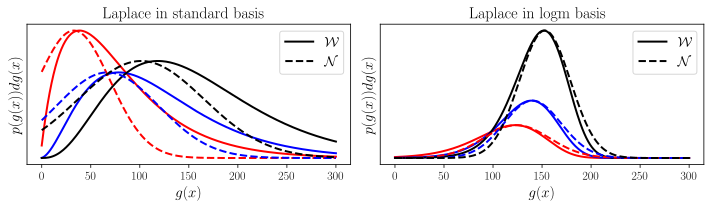

In [13]:
# test the function for one value of rho and s

""" values """
a_11 = np.linspace(0.1, 20.1, 300 +1)
a_22 = np.linspace(0.1, 20.1, 300 +1)

a_11_t = np.linspace(0.1, 5.1, 300 +1)
a_22_t = np.linspace(0.1, 5.1, 300 +1)

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

#s = np.eye(2)

#s = create_spd_matrix(eps=3)
print(s)

is_pos_def(s)

r = 0.25
xx = make_2D_psd_cone_cut(a_11, a_22, r)
xxt = make_2D_psd_cone_cut(a_11_t, a_22_t, r)

n1 = 4
n2 = 5
n3 = 6

p=2

plot_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=True, 
                         filename='wishart_logm_bridge.pdf', show_back=False)


-0.9
(301, 2, 2)


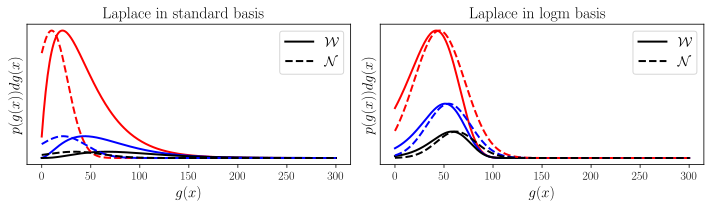

-0.8
(301, 2, 2)


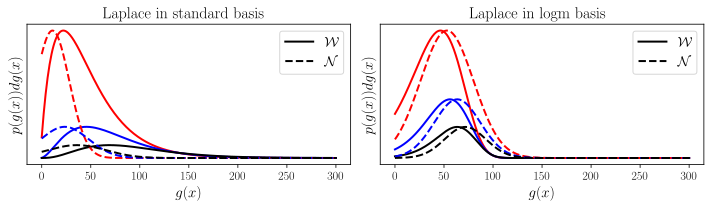

-0.7
(301, 2, 2)


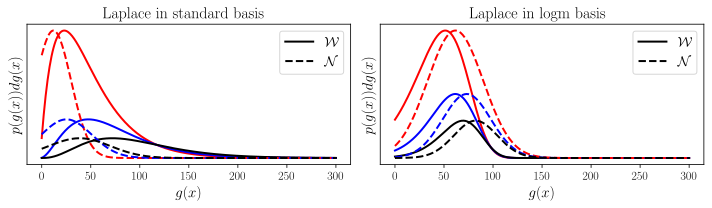

-0.6
(301, 2, 2)


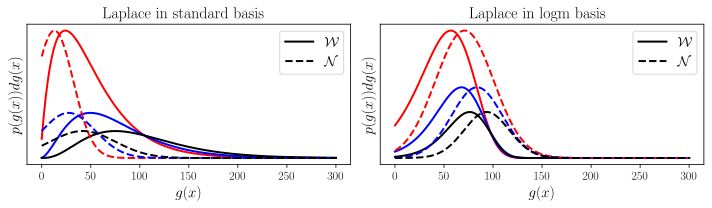

-0.5
(301, 2, 2)


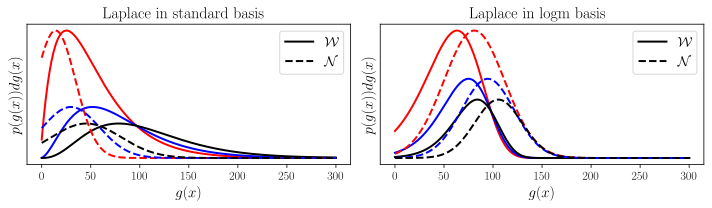

-0.4
(301, 2, 2)


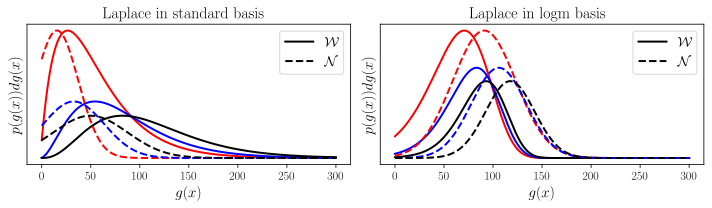

-0.29999999999999993
(301, 2, 2)


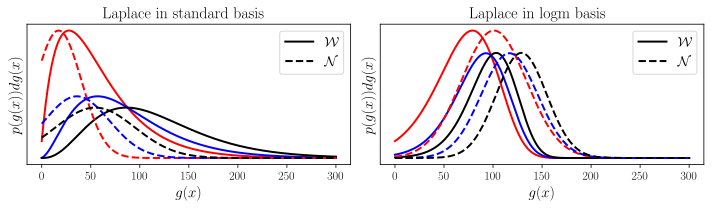

-0.19999999999999996
(301, 2, 2)


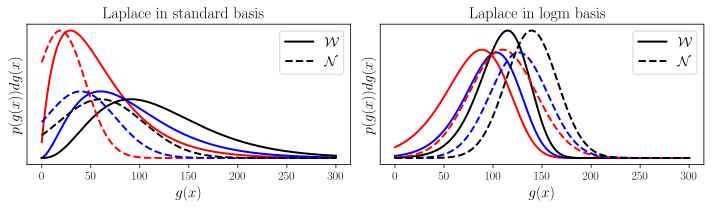

-0.09999999999999998
(301, 2, 2)


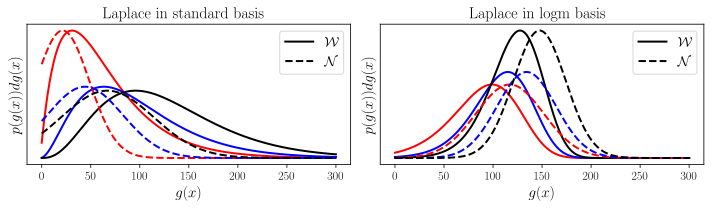

0.0
(301, 2, 2)


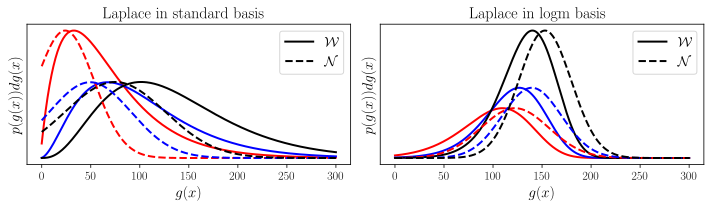

0.09999999999999998
(301, 2, 2)


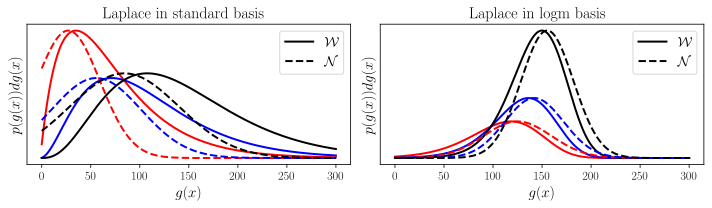

0.20000000000000007
(301, 2, 2)


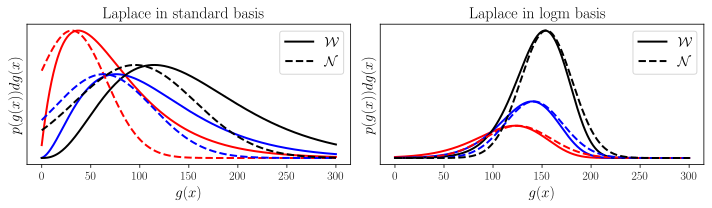

0.30000000000000016
(301, 2, 2)


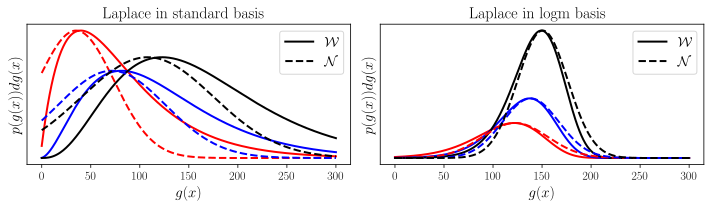

0.4
(301, 2, 2)


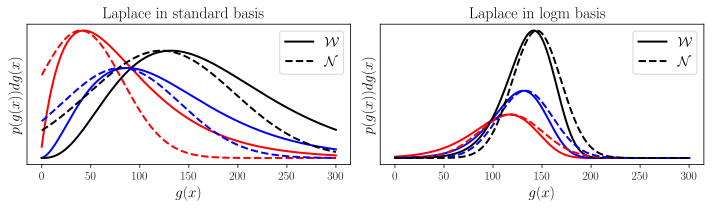

0.5000000000000001
(301, 2, 2)


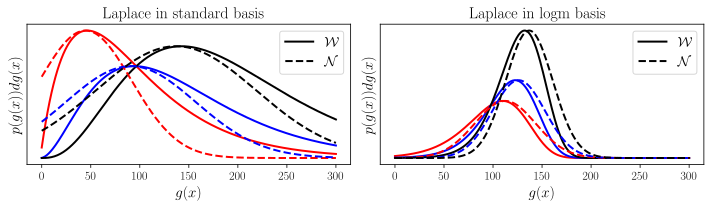

0.6
(301, 2, 2)


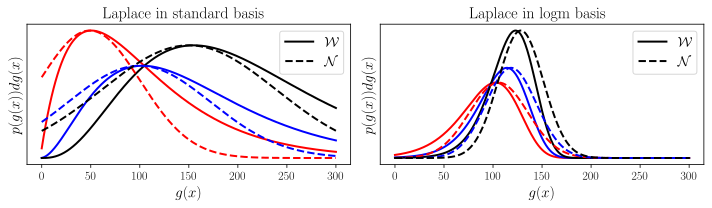

0.7000000000000001
(301, 2, 2)


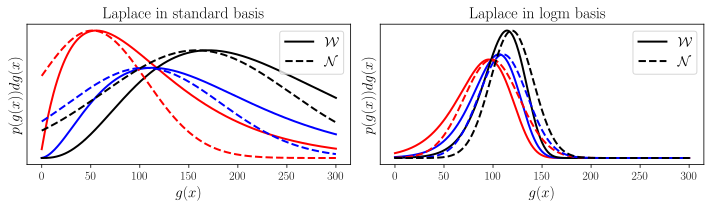

0.8000000000000002
(301, 2, 2)


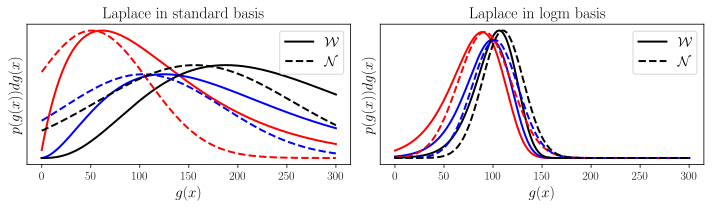

0.9
(301, 2, 2)


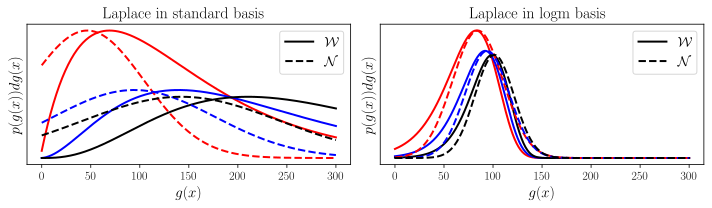

In [14]:
# test the function for multiple values of rho and s

""" values """

#s = np.eye(2)

s = np.array([[4,2],
             [2,3]])

#s = np.array([[5,3],
#             [3,4]])

is_pos_def(s)

n1 = 4
n2 = 5
n3 = 6

p=2

rhos = np.linspace(-0.9, 0.9, 19)

for r in rhos:
    
    print(r)
    xx = make_2D_psd_cone_cut(a_11, a_22, r)
    xxt = make_2D_psd_cone_cut(a_11_t, a_22_t, r)
    plot_Wishart_bridge_logm(xx=xx, xxt=xxt, ns=[n1,n2,n3], s=s, p=2, save=False, 
                             filename='delete.pdf', show_back=False)

# Verify the Bridge

In [15]:
n_test = 5
p_test = 2
s_test = np.array([[4,2],
                   [2,3]])

is_pos_def(s_test)

def wishart_t_logm_mode(n, p, V):
    return(logm((n-p+1) * V))

def wishart_t_logm_Sigma(n, p, V):
    return(2/(n-p+1) * np.eye(p**2))

def wishart_t_logm_V_from_mS(mu, Sigma, p, n):
    mu_ = mu.reshape(p,p)
    return(expm(mu_)/(n-p+1))

def wishart_t_logm_n_from_mS(mu, Sigma, p, V):
    mu_ = mu.reshape(p,p)
    return(expm(mu)@np.linalg.inv(V) + (p-1)*np.eye(p))

def wishart_t_logm_n_from_mS2(mu, Sigma, p):
    S_inv = np.linalg.inv(Sigma)
    print("S_inv: ", S_inv)
    return(2*S_inv + (p-1)*np.eye(p**2))

m_test = wishart_t_logm_mode(n_test, p_test, s_test)
S_test = wishart_t_logm_Sigma(n_test, p_test, s_test)
V_test = wishart_t_logm_V_from_mS(m_test, S_test, p_test, n_test)
print("m_test: ", m_test)
print("S_test: ", S_test)

n2_test = wishart_t_logm_n_from_mS(m_test, S_test, p_test, V_test)
n3_test = wishart_t_logm_n_from_mS2(m_test, S_test, p_test)

print(V_test)
print(n2_test)
print(n3_test)

m_test:  [[2.59000719 0.65596824]
 [0.65596824 2.26202307]]
S_test:  [[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]
S_inv:  [[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]
[[4. 2.]
 [2. 3.]]
[[5. 0.]
 [0. 5.]]
[[5. 0. 0. 0.]
 [0. 5. 0. 0.]
 [0. 0. 5. 0.]
 [0. 0. 0. 5.]]


In [16]:
#TODO: this is wrong. Redo




X_spd is spd:  True
S_inv:  [[  4.384781    1.6266444 -11.721093    6.348332 ]
 [  1.6266444   2.3424695  -8.701692    4.8365364]
 [-11.721093   -8.701692   47.413727  -26.33537  ]
 [  6.348332    4.8365364 -26.33537    15.135254 ]]
X_test:  [[0.93635595 0.6574877  0.51576567 0.29458493]
 [0.6574877  1.8031368  0.60352474 0.19815722]
 [0.51576567 0.60352474 0.95639974 1.2549455 ]
 [0.29458493 0.19815722 1.2549455  2.0627956 ]]
V2_test:  [[ 0.30492326 -0.5578294 ]
 [-0.27030487  0.5569773 ]]
m_:  [0.16436018 0.33963554 0.16457566 0.77821461]
n2_test:  [[  9.76956177   3.25328875 -23.44218636  12.69666386]
 [  3.25328875   5.68493891 -17.40338326   9.67307281]
 [-23.44218636 -17.40338326  95.82745361 -52.67073822]
 [ 12.69666386   9.67307281 -52.67073822  31.27050781]]
singular values:  [134.33157214   4.53838275   2.08187387   1.60063334]
U:  [[-0.21061232  0.87217308 -0.31119587  0.31323105]
 [-0.15471946 -0.46274734 -0.759915    0.42948339]
 [ 0.84250938  0.04859387  0.09707515  0.527

# Statistical distance measures

In [17]:
from torch_two_sample import MMDStatistic
from scipy.stats import wishart
from scipy.stats import multivariate_normal as mv_norm
import torch

## starting with MMD for 25 pairs of parameters

In [18]:
def MMD_combinations(params, plot=False, n_samples=1000, verbose=True):
    
    Ns = params[0]
    Vs = params[1]
    p = np.shape(Vs[0])[0]
    
    MMD_sum = 0
    MMD_t_logm_sum = 0 
    MMD_t_sqrtm_sum = 0 

    for n in Ns:
        for v in Vs:
            
            if verbose:
                print("n: ", n, "V: ", v)

            if n <= p + 1:
                print("n <= p+1 doesn't yield a Laplace Approximation in standard basis")

            #get samples from all dists
            #standard
            W_samples = wishart.rvs(n, v, size=n_samples)
            if n > p+1:         
                mode1 = wishart_mode(n, p, v).reshape(-1)
                Sigma1 = wishart_Sigma(n, p, v)
                N_samples = mv_norm.rvs(mode1, Sigma1, size=n_samples)

            #logm
            mode1_logm = wishart_t_logm_mode(n, p, v).reshape(-1)
            Sigma1_logm = wishart_t_logm_Sigma(n, p, v)
            W_samples_logm = np.array([logm(w) for w in W_samples])
            N_samples_logm = mv_norm.rvs(mode1_logm, Sigma1_logm, size=n_samples)
            
            
            #sqrtm
            mode1_sqrtm = wishart_t_sqrtm_mode(n, p, v).reshape(-1)
            Sigma1_sqrtm = wishart_t_sqrtm_Sigma(n, p, v)
            W_samples_sqrtm = np.array([sqrtm(w) for w in W_samples])
            N_samples_sqrtm = mv_norm.rvs(mode1_sqrtm, Sigma1_sqrtm, size=n_samples)


            #calculate MMD for all bases
            MMD = MMDStatistic(n_samples, n_samples)

            #standard
            W_samples_ = torch.Tensor(W_samples.reshape((n_samples, -1)))
            if n > p+1:         
                N_samples_ = torch.Tensor(N_samples.reshape((n_samples, -1)))
                MMD_ = MMD(W_samples_, N_samples_,  alphas=[0.5], ret_matrix=False)
                MMD_ = torch.max(torch.zeros(1), MMD_)
            else:
                MMD_ = torch.Tensor([np.nan])

            #logm
            W_samples_logm_ = torch.Tensor(W_samples_logm.reshape((n_samples, -1)))
            N_samples_logm_ = torch.Tensor(N_samples_logm.reshape((n_samples, -1)))
            MMD_logm_= MMD(W_samples_logm_, N_samples_logm_,  alphas=[0.5], ret_matrix=False)
            MMD_logm_= torch.max(torch.zeros(1), MMD_logm_)
            
            #sqrtm
            W_samples_sqrtm_ = torch.Tensor(W_samples_sqrtm.reshape((n_samples, -1)))
            N_samples_sqrtm_ = torch.Tensor(N_samples_sqrtm.reshape((n_samples, -1)))
            MMD_sqrtm_= MMD(W_samples_sqrtm_, N_samples_sqrtm_,  alphas=[0.5], ret_matrix=False)
            MMD_sqrtm_= torch.max(torch.zeros(1), MMD_sqrtm_)

            if plot:
                rhos = np.linspace(-0.9, 0.9, 19)
                
                print("Logm base")
                for r in rhos:
                    
                    print(r)
                    xx = make_2D_psd_cone_cut(a_11, a_22, r)
                    plot_Wishart_bridge_logm(xx=xx, ns=[n, n, n], s=v, p=2, save=False, filename='')

                print("Sqrtm base")
                for r in rhos:
                    
                    print(r)
                    xx = make_2D_psd_cone_cut(a_11, a_22, r)
                    plot_Wishart_bridge_sqrtm(xx=xx, ns=[n, n, n], s=v, p=2, save=False, filename='')

            if verbose: 
                print("standard: ", MMD_.item(), "logm: ", MMD_logm_.item(), "sqrtm: ", MMD_sqrtm_.item())

            #add them to their respective sums
            MMD_sum += MMD_
            MMD_t_logm_sum += MMD_logm_
            MMD_t_sqrtm_sum += MMD_sqrtm_

    return(MMD_sum.item(), MMD_t_logm_sum.item(), MMD_t_sqrtm_sum.item())

In [19]:
np.random.seed(42)
random_Vs = [create_spd_matrix(p=3, eps=10e-3) for _ in range(5)]
MMD_combinations(params=[range(4,9), random_Vs], plot=False, verbose=True, n_samples=2000)

X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
X_spd is spd:  True
n:  4 V:  [[0.6314786  0.7575672  0.47749832]
 [0.7575672  0.9527247  0.47123465]
 [0.47749832 0.47123465 1.0142767 ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 1.1683311876551728e-06
standard:  nan logm:  0.07412392646074295 sqrtm:  0.1749490201473236
n:  4 V:  [[1.1824476  0.818614   0.5547934 ]
 [0.818614   0.6817384  0.70550704]
 [0.5547934  0.70550704 1.2829249 ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 5.777317393168541e-07


/home/marius/anaconda3/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


standard:  nan logm:  0.07036604732275009 sqrtm:  0.15199892222881317
n:  4 V:  [[0.9914206  0.7923632  0.89940935]
 [0.7923632  1.1684995  0.21368411]
 [0.89940935 0.21368411 1.340486  ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 5.978465911442362e-07
standard:  nan logm:  0.07215219736099243 sqrtm:  0.13567394018173218
n:  4 V:  [[0.5719051  0.51653004 0.44032633]
 [0.51653004 0.5457329  0.5179137 ]
 [0.44032633 0.5179137  0.8211103 ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 2.8254862900926204e-07
standard:  nan logm:  0.05248885229229927 sqrtm:  0.1847921907901764
n:  4 V:  [[1.5922433  0.9593822  0.7710688 ]
 [0.9593822  0.72036004 0.66753215]
 [0.7710688  0.66753215 0.6966943 ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
logm result may be inaccurate, approximate err = 1.5791062768614845e-06
standard:  nan logm:  0.

(nan, 2.1734731197357178, 2.74407958984375)

In [20]:
results_MMD = np.array([5.249842643737793, 2.105339765548706, 3.1880857944488525])
results_MMD_normed = results_MMD/results_MMD[0]
print(results_MMD_normed)

[1.         0.40102912 0.60727264]


# KL div from samples, attempt 2

In [21]:
def KL_div_samples_wishart2(n, V, num_samples, base='standard', plot=False):
    
    wishart_samples = wishart.rvs(n, V, size=num_samples)
    #bin_size = int(num_samples**0.25)
    assert(base in ['standard', 'logm', 'sqrtm'])
    
    p = V[0].shape[0]
    
    if base == 'logm':
    
        wishart_samples_logm = np.array([logm(s) for s in wishart_samples]).reshape(num_samples, -1)
        mu_wishart_logm = wishart_t_logm_mode(n, p, V).reshape(-1)
        Sigma_wishart_logm_inv = wishart_t_logm_Sigma_inv(n, p, V)

        s = np.array(wishart_samples_logm).reshape(num_samples, p, p)
        p_ = np.array([wishart_pdf_t_logm(s_, n, V) for s_ in s])
        s = s.reshape(num_samples, -1)
        q_ = np.array([multivariate_normal_pdf_test_sym(s_, mu_wishart_logm, Sigma_wishart_logm_inv) for s_ in s])
        #q_ = np.array([multivariate_normal_pdf_test_exp_log(s_, mu_wishart_logm, Sigma_wishart_logm) for s_ in s])
        KL_div_logm_ = np.mean(np.log(p_) - np.log(q_) + 1e-4) #numerical stability because logm approx not perfect
        
        if plot:
            pass

        return(KL_div_logm_)
    
    elif base == 'sqrtm':
    
        wishart_samples_sqrtm = np.array([sqrtm(s) for s in wishart_samples]).reshape(num_samples, -1)
        #print(wishart_samples_sqrtm[:10])
        mu_wishart_sqrtm = wishart_t_sqrtm_mode(n, p, V).reshape(-1)
        Sigma_wishart_sqrtm_inv = wishart_t_sqrtm_Sigma_inv(n, p, V)
        #Sigma_wishart_sqrtm_det = wishart_t_sqrtm_Sigma_inv(n, p, V)
        #Sigma_wishart_sqrtm = wishart_t_sqrtm_Sigma(n, p, V)

        s = np.array(wishart_samples_sqrtm).reshape(num_samples, p, p)
        p_ = np.array([wishart_pdf_t_sqrtm(s_, n, V) for s_ in s])
        s = s.reshape(num_samples, -1)
        q_ = np.array([multivariate_normal_pdf_test_sym(s_, mu_wishart_sqrtm, Sigma_wishart_sqrtm_inv) for s_ in s])
        #q_ = np.array([multivariate_normal_pdf_test_exp_log(s_, mu_wishart_sqrtm, Sigma_wishart_sqrtm) for s_ in s])
        KL_div_sqrtm_ = np.mean(np.log(p_) - np.log(q_))
        
        if plot:
            pass

        return(KL_div_sqrtm_)
    
    elif base == 'standard':
    
        wishart_samples = wishart_samples.reshape(num_samples, -1)
        mu_wishart = wishart_mode(n, p, V).reshape(-1)
        Sigma_wishart = wishart_Sigma(n, p, V)

        s = np.array(wishart_samples).reshape(num_samples, p, p)
        p_ = np.array([wishart.pdf(s_, n, V) for s_ in s])
        s = s.reshape(num_samples, -1)
        q_ = mv_norm.pdf(s, mu_wishart, Sigma_wishart)
        #q_ = np.array([multivariate_normal_pdf_test(s_, mu_wishart, Sigma_wishart) for s_ in s])
        KL_div_ = np.mean(np.log(p_/q_))
        
        if plot:
            pass

        return(KL_div_)



In [22]:
def KL_div_samples_combinations2(params, num_samples, plot=False, verbose=True):
    
    KL_div_sum = 0
    KL_div_logm_sum = 0
    KL_div_sqrtm_sum = 0

    for Ps in params:
        
        n, V = Ps
        p = np.shape(V)[0]

        if verbose:
            print("n: ", n, "V: ", V, "p: ", p)

        if n <= p + 1:
            print("Wishart has no valid Laplace Approximation in standard base for n <= p+1")
            KL_div_ = np.nan
        else:
            KL_div_ = KL_div_samples_wishart2(n, V, num_samples=num_samples, base='standard', plot=False)                
        KL_div_sum += KL_div_
            
        #compute KL-div for log base
        KL_div_logm_ = KL_div_samples_wishart2(n, V, num_samples=num_samples, base='logm', plot=False)
        KL_div_logm_sum += KL_div_logm_
        
        #compute KL-div for log base
        KL_div_sqrtm_ = KL_div_samples_wishart2(n, V, num_samples=num_samples, base='sqrtm', plot=False)
        KL_div_sqrtm_sum += KL_div_sqrtm_
        


        if verbose:
            print("standard: ", KL_div_, "logm: ", KL_div_logm_, "sqrtm: ", KL_div_sqrtm_)

    return(KL_div_sum, KL_div_logm_sum, KL_div_sqrtm_sum)

In [23]:
V_test = np.eye(2)#np.array([[3, 2], [2, 4]])

n1_test, V1_test = 2, V_test #np.eye(2)
n2_test, V2_test = 3, V_test #2*np.eye(2)
n3_test, V3_test = 4, V_test #3*np.eye(2)
n4_test, V4_test = 7, V_test #3*np.eye(2)

wishart_params = [[n1_test, V1_test], [n2_test, V2_test], [n3_test, V3_test], [n4_test, V4_test]]

In [24]:
KL_div_samples_combinations2(wishart_params, num_samples=10000)

n:  2 V:  [[1. 0.]
 [0. 1.]] p:  2
Wishart has no valid Laplace Approximation in standard base for n <= p+1
standard:  nan logm:  3.7305156558565526 sqrtm:  4.709746026992951
n:  3 V:  [[1. 0.]
 [0. 1.]] p:  2
Wishart has no valid Laplace Approximation in standard base for n <= p+1
standard:  nan logm:  1.6165263737913593 sqrtm:  1.3916539092061266
n:  4 V:  [[1. 0.]
 [0. 1.]] p:  2
standard:  9.32369565141261 logm:  1.029135470142633 sqrtm:  0.9356897047934625
n:  7 V:  [[1. 0.]
 [0. 1.]] p:  2
standard:  4.100339380645353 logm:  2.1737055029793617 sqrtm:  2.3897835148267887


(nan, 8.549883002769906, 9.42687315581933)

# Compute KL divergence for increasing $\theta$

In [41]:
n_0, V_0 = 2.5,  0.25 * np.array([[1.5,1], [1,2]])
Ns = np.array([n_0 + 0.5*i for i in range(10)])
Vs = np.array([V_0 + V_0*0.5*i for i in range(10)])
NVs = list(zip(Ns, Vs))
print(NVs)

[(2.5, array([[0.375, 0.25 ],
       [0.25 , 0.5  ]])), (3.0, array([[0.5625, 0.375 ],
       [0.375 , 0.75  ]])), (3.5, array([[0.75, 0.5 ],
       [0.5 , 1.  ]])), (4.0, array([[0.9375, 0.625 ],
       [0.625 , 1.25  ]])), (4.5, array([[1.125, 0.75 ],
       [0.75 , 1.5  ]])), (5.0, array([[1.3125, 0.875 ],
       [0.875 , 1.75  ]])), (5.5, array([[1.5, 1. ],
       [1. , 2. ]])), (6.0, array([[1.6875, 1.125 ],
       [1.125 , 2.25  ]])), (6.5, array([[1.875, 1.25 ],
       [1.25 , 2.5  ]])), (7.0, array([[2.0625, 1.375 ],
       [1.375 , 2.75  ]]))]


In [46]:
KL_results_linear = []

for s in range(1): #10):
    print("seed: ", s)
    np.random.seed(s)
    
    results_seed = []
    for nv_ in NVs:
        n_, v_ = nv_
        #print(n_, v_)
        KL_ = KL_div_samples_combinations2([[n_, v_]], verbose=True, num_samples=10000)
        print(KL_)
        results_seed.append(KL_)
    
    KL_results_linear.append(results_seed)

seed:  0
n:  2.5 V:  [[0.375 0.25 ]
 [0.25  0.5  ]] p:  2
Wishart has no valid Laplace Approximation in standard base for n <= p+1
standard:  nan logm:  3.2801570249687173 sqrtm:  2.3100183534115706
(nan, 3.2801570249687173, 2.3100183534115706)
n:  3.0 V:  [[0.5625 0.375 ]
 [0.375  0.75  ]] p:  2
Wishart has no valid Laplace Approximation in standard base for n <= p+1
standard:  nan logm:  2.1765679436037626 sqrtm:  1.4220382879491142
(nan, 2.1765679436037626, 1.4220382879491142)
n:  3.5 V:  [[0.75 0.5 ]
 [0.5  1.  ]] p:  2
standard:  17.316590495038998 logm:  1.490948320874412 sqrtm:  0.9385837786619528
(17.316590495038998, 1.490948320874412, 0.9385837786619528)
n:  4.0 V:  [[0.9375 0.625 ]
 [0.625  1.25  ]] p:  2
standard:  9.169140930869256 logm:  1.063595475333901 sqrtm:  0.7101745349809213
(9.169140930869256, 1.063595475333901, 0.7101745349809213)
n:  4.5 V:  [[1.125 0.75 ]
 [0.75  1.5  ]] p:  2
standard:  6.919082311172229 logm:  0.8163879915256255 sqrtm:  0.6411417083015057
(6.9

In [47]:
# handle the data
KL_results_linear = np.array(KL_results_linear)

# take the mean over the 10 seeds
KL_results_linear_mean = KL_results_linear.mean(0)
print(np.shape(KL_results_linear_mean))

(10, 3)


In [48]:
KL_results_linear_mean

array([[        nan,  3.28015702,  2.31001835],
       [        nan,  2.17656794,  1.42203829],
       [17.3165905 ,  1.49094832,  0.93858378],
       [ 9.16914093,  1.06359548,  0.71017453],
       [ 6.91908231,  0.81638799,  0.64114171],
       [ 5.88446707,  0.79575321,  0.69476211],
       [ 5.28643816,  0.78332584,  0.85496935],
       [ 4.98686658,  0.93508764,  1.09027404],
       [ 4.84655126,  1.15372336,  1.40320671],
       [ 4.77552249,  1.43640858,  1.77686407]])

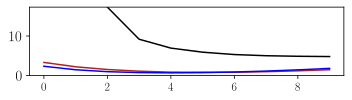

In [49]:
# make plots

fig = plt.figure(figsize=(5, 1.5))
plt.plot(KL_results_linear_mean[:,0], label='standard base', color='black')
plt.plot(KL_results_linear_mean[:,1], label='logm base', color='firebrick')
plt.plot(KL_results_linear_mean[:,2], label='sqrtm base', color='blue')
plt.ylim(0, np.nanmax(KL_results_linear_mean))
plt.tight_layout()

#"""
tpl.save(
    "KL_Wishart.tex",
    figure = fig,
    axis_width = "\\figwidth",
    axis_height= "\\figheight",
    tex_relative_path_to_data=".",
    override_externals=True,
    float_format=".3g"
)
#"""

plt.savefig('KL_Wishart.pdf')

plt.show();

# calculate MMD for growing ns and Vs and plot it

In [42]:
MMD_results_linear = []

for s in range(1):
    print("seed: ", s)
    np.random.seed(s)
    
    results_seed = []
    for nv_ in NVs:
        n_, v_ = nv_
        MMD_ = MMD_combinations(params = [[n_], [v_]], n_samples=2000)
        print(MMD_)
        results_seed.append(MMD_)
    
    MMD_results_linear.append(results_seed)

seed:  0
n:  2.5 V:  [[0.375 0.25 ]
 [0.25  0.5  ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
standard:  nan logm:  0.03080354630947113 sqrtm:  0.1269824504852295
(nan, 0.03080354630947113, 0.1269824504852295)
n:  3.0 V:  [[0.5625 0.375 ]
 [0.375  0.75  ]]
n <= p+1 doesn't yield a Laplace Approximation in standard basis
standard:  nan logm:  0.032565124332904816 sqrtm:  0.09113186597824097
(nan, 0.032565124332904816, 0.09113186597824097)
n:  3.5 V:  [[0.75 0.5 ]
 [0.5  1.  ]]
standard:  0.1585659384727478 logm:  0.03724062442779541 sqrtm:  0.08130714297294617
(0.1585659384727478, 0.03724062442779541, 0.08130714297294617)
n:  4.0 V:  [[0.9375 0.625 ]
 [0.625  1.25  ]]
standard:  0.040370628237724304 logm:  0.030254125595092773 sqrtm:  0.07193011045455933
(0.040370628237724304, 0.030254125595092773, 0.07193011045455933)
n:  4.5 V:  [[1.125 0.75 ]
 [0.75  1.5  ]]
standard:  0.014024811796844006 logm:  0.02809235453605652 sqrtm:  0.05986453592777252
(0.01402481179684

In [43]:
# handle the data
MMD_results_linear = np.array(MMD_results_linear)

# take the mean over the 10 seeds
MMD_results_linear_mean = MMD_results_linear.mean(0)
print(np.shape(MMD_results_linear_mean))

(10, 3)


In [44]:
MMD_results_linear_mean

array([[       nan, 0.03080355, 0.12698245],
       [       nan, 0.03256512, 0.09113187],
       [0.15856594, 0.03724062, 0.08130714],
       [0.04037063, 0.03025413, 0.07193011],
       [0.01402481, 0.02809235, 0.05986454],
       [0.00748392, 0.02752352, 0.05678618],
       [0.00426031, 0.02564588, 0.05042188],
       [0.00273487, 0.02517644, 0.04588509],
       [0.00174517, 0.02144   , 0.0460684 ],
       [0.00109942, 0.02113044, 0.03694653]])

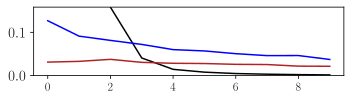

In [45]:
# make plots

fig = plt.figure(figsize=(5, 1.5))
plt.plot(MMD_results_linear_mean[:,0], label='standard base', color='black')
plt.plot(MMD_results_linear_mean[:,1], label='logm base', color='firebrick')
plt.plot(MMD_results_linear_mean[:,2], label='sqrtm base', color='blue')
plt.ylim(0, np.nanmax(MMD_results_linear_mean))
plt.tight_layout()

#"""
tpl.save(
    "MMD_Wishart.tex",
    figure = fig,
    axis_width = "\\figwidth",
    axis_height= "\\figheight",
    tex_relative_path_to_data=".",
    override_externals=True,
    float_format=".3g"
)
#"""

plt.savefig('MMD_Wishart.pdf')

plt.show();